# Explicit Feedback Neural Recommender Systems

Goals:
- Understand recommender data
- Build different models architectures using Keras
- Retrieve Embeddings and visualize them
- Add metadata information as input to the model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from zipfile import ZipFile
from urllib.request import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = Path(ML_100K_URL.rsplit('/', 1)[1])
ML_100K_FOLDER = Path('ml-100k')

if not ML_100K_FILENAME.exists():
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME.name)

if not ML_100K_FOLDER.exists():
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME.name).extractall('.')

### Ratings file

Each line contains a rated movie: 
- a user
- an item
- a rating from 1 to 5 stars

In [2]:
import pandas as pd

all_ratings = pd.read_csv(ML_100K_FOLDER / 'u.data', sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])
all_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


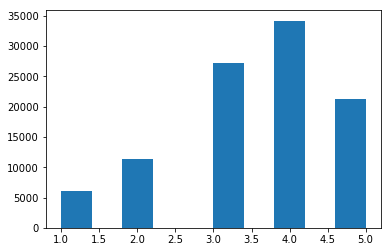

In [3]:
import matplotlib.pyplot as plt
plt.hist(all_ratings.rating)
plt.show()

### Item metadata file

The item metadata file contains metadata like the name of the movie or the date it was released

In [4]:
names = ["name", "date", "genre", "url"]
names += ["f" + str(x) for x in range(19)]  # unused feature names

items = pd.read_csv(ML_100K_FOLDER / 'u.item', sep='|', encoding='latin-1',
                    names=names)
# fix a missing value
items.fillna(value="01-Jan-1997", inplace=True)
items.head()

,name,date,genre,url,f0,f1,f2,f3,f4,f5,...,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18
1,Toy Story (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Data preprocessing

To understand well the distribution of the data, the following statistics are computed:
- the number of users
- the number of items
- the rating distribution

In [5]:
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [6]:
max_user_id = all_ratings['user_id'].max()
max_user_id

943

In [9]:
max_item_id = all_ratings['item_id'].max()
max_item_id

1682

In [10]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']

# Explicit feedback: supervised ratings prediction

For each pair of (user, item) try to predict the rating the user would give to the item.

This is the classical setup for building recommender systems from offline data with explicit supervision signal. 

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="images/rec_archi_1.svg" style="width: 600px;" />

In [11]:
from keras.layers import Input, Embedding, Flatten, merge, Dense, Dropout, Lambda
from keras.models import Model
import keras.backend as K
from keras_fixes import dot_mode

Using TensorFlow backend.


In [12]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

y = merge([user_vecs, item_vecs], mode=dot_mode, output_shape=(1,))

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mae')

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
item (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
user_embedding (Embedding)       (None, 1, 30)         28320       user[0][0]                       
____________________________________________________________________________________________________
item_embedding (Embedding)       (None, 1, 30)         50490       item[0][0]                       
___________________________________________________________________________________________

In [16]:
# Useful for debugging the output shape of model
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds.shape

(80000,)

### Model error

Using `initial_train_preds`, compute the model errors:
- mean absolute error
- mean squared error

Converting a pandas Series to numpy array is usually implicit, but you may use `rating_train.values` to do so explicitely. Be sure to monitor the shapes of each object you deal with by using `object.shape`.

In [23]:
initial_train_preds.shape, rating_train.values.shape

((80000,), (80000,))

In [24]:
# %load solutions/compute_errors.py
squared_differences = np.square(initial_train_preds - rating_train.values)
absolute_differences = np.abs(initial_train_preds - rating_train.values)

print("Random init MSE: %0.3f" % np.mean(squared_differences))
print("Random init MAE: %0.3f" % np.mean(absolute_differences))

# You may also use sklearn metrics to do so with less numpy engineering 
#from sklearn.metrics import mean_squared_error, mean_absolute_error
#
#print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
#print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))


Random init MSE: 13.732
Random init MAE: 3.531


### Monitoring runs

Keras enables to monitor various variables during training. 

`history.history` returned by the `model.fit` function is a dictionary
containing the `'loss'` and validation loss `'val_loss'` after each epoch

In [25]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=6, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/6
72000/72000 [==============================] - 4s - loss: 2.9594 - val_loss: 1.4748
Epoch 2/6
72000/72000 [==============================] - 5s - loss: 1.1168 - val_loss: 0.9948
Epoch 3/6
72000/72000 [==============================] - 6s - loss: 0.9465 - val_loss: 0.9476
Epoch 4/6
72000/72000 [==============================] - 5s - loss: 0.9208 - val_loss: 0.9339
Epoch 5/6
72000/72000 [==============================] - 4s - loss: 0.9122 - val_loss: 0.9285
Epoch 6/6
72000/72000 [==============================] - 4s - loss: 0.9088 - val_loss: 0.9264
Wall time: 31.6 s


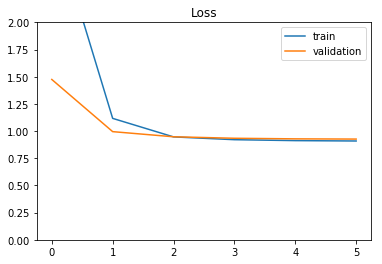

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

Now that the model is trained, the model MSE and MAE look nicer:

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 1.412
Final test MAE: 0.897


In [28]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 1.407
Final train MAE: 0.898


## A Deep recommender model

Using a similar framework as previously, the following deep model described in the course was built (with only two fully connected)

<img src="images/rec_archi_2.svg" style="width: 600px;" />


### Exercise

- The following code has **4 errors** that prevent it from working correctly. **Correct them and explain** why they are critical.

In [31]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')
# Error 1: here the dropout coefficient was too high: underfitting
input_vecs = Dropout(0.5)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
# Error 2: we predict only 1-d ratings, not 2-d
# Error 3: we do not want any tanh activation for output lalyer, since 
# we want values from 1 to 5!
y = Dense(1)(x)

model = Model(input=[user_id_input, item_id_input], output=y)
# Error 4: use a regression metrics, not a classification one
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train])

In [30]:
# %load solutions/deep_explicit_feedback_recsys.py

In [32]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=5, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 6s - loss: 1.0103 - val_loss: 0.7673
Epoch 2/5
72000/72000 [==============================] - 5s - loss: 0.7528 - val_loss: 0.7542
Epoch 3/5
72000/72000 [==============================] - 6s - loss: 0.7378 - val_loss: 0.7513
Epoch 4/5
72000/72000 [==============================] - 5s - loss: 0.7319 - val_loss: 0.7551
Epoch 5/5
72000/72000 [==============================] - 6s - loss: 0.7260 - val_loss: 0.7452
Wall time: 30.8 s


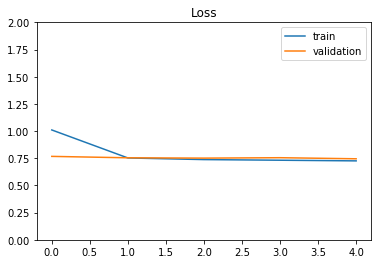

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [34]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.929
Final test MAE: 0.730


In [35]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 0.862
Final train MAE: 0.698


In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
item (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
user_embedding (Embedding)       (None, 1, 30)         28320       user[0][0]                       
____________________________________________________________________________________________________
item_embedding (Embedding)       (None, 1, 30)         50490       item[0][0]                       
___________________________________________________________________________________________

### Home assignment: 
 - Add another layer, compare train/test error
 - What do you notice? 
 - Try adding more dropout and modifying layer sizes: should you increase
   or decrease the number of parameters

In [42]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')
input_vecs = Dropout(0.5)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
# We add another layer
layer = Dense(64, activation='relu')(x)
layer = Dropout(0.5)(layer)


y = Dense(1)(layer)

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train])

In [43]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=5, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 7s - loss: 1.0572 - val_loss: 0.8017
Epoch 2/5
72000/72000 [==============================] - 6s - loss: 0.8916 - val_loss: 0.7865
Epoch 3/5
72000/72000 [==============================] - 6s - loss: 0.8491 - val_loss: 0.7680
Epoch 4/5
72000/72000 [==============================] - 6s - loss: 0.8176 - val_loss: 0.7603
Epoch 5/5
72000/72000 [==============================] - 6s - loss: 0.7919 - val_loss: 0.7647
Wall time: 34.2 s


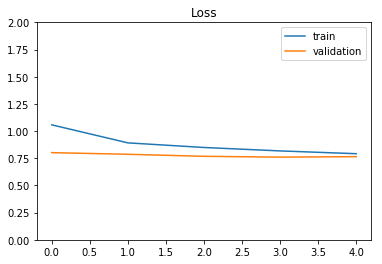

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [45]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final test MSE: 0.903
Final test MAE: 0.754
Final train MSE: 0.846
Final train MAE: 0.728


In [46]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
item (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
user_embedding (Embedding)       (None, 1, 30)         28320       user[0][0]                       
____________________________________________________________________________________________________
item_embedding (Embedding)       (None, 1, 30)         50490       item[0][0]                       
___________________________________________________________________________________________

### Model Embeddings

- It is possible to retrieve the embeddings by simply using the Keras function `model.get_weights` which returns all the model learnable parameters.
- The weights are returned the same order as they were build in the model
- What is the total number of parameters?

In [47]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 30), (1683, 30), (60, 64), (64,), (64, 64), (64,), (64, 1), (1,)]

In [67]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
item (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
user_embedding (Embedding)       (None, 1, 30)         28320       user[0][0]                       
____________________________________________________________________________________________________
item_embedding (Embedding)       (None, 1, 30)         50490       item[0][0]                       
___________________________________________________________________________________________

In [66]:
# Solution: 
# model.summary()

In [72]:
user_embeddings = weights[0]
item_embeddings = weights[1]
print("First item name from metadata:", items["name"][1])
print("Embedding vector for the first item:")
print(item_embeddings[1])
print("shape:", item_embeddings[1].shape)

First item name from metadata: Toy Story (1995)
Embedding vector for the first item:
[  5.91379441e-02  -3.81382890e-02  -1.12092577e-01  -8.08542147e-02
   2.30634678e-02  -3.47638540e-02  -5.65975606e-02  -3.87772061e-02
  -2.72217912e-05   5.97733036e-02  -2.97536049e-02   7.92540237e-02
   9.02471542e-02  -7.73700923e-02   7.64738545e-02   5.85318096e-02
   1.06474482e-01   6.39893189e-02   5.92335276e-02   5.67633891e-03
  -7.51887560e-02  -3.87150832e-02   7.47264028e-02   6.12891465e-03
  -6.57765195e-03   3.21295187e-02   7.13947415e-02   2.87377499e-02
  -9.34266821e-02  -1.02235368e-02]
shape: (30,)


### Finding most similar items
Finding k most similar items to a point in embedding space

- Write in numpy a function to compute the cosine similarity between two points in embedding space
- Write a function which computes the euclidean distance between a point in embedding space and all other points
- Write a most similar function, which returns the k item names with lowest euclidean distance
- Try with a movie index, such as 181 (Return of the Jedi). What do you observe? Don't expect miracles on such a small training set.

Notes:
- you may use `np.linalg.norm` to compute the norm of vector, and you may specify the `axis=`
- the numpy function `np.argsort(...)` enables to compute the sorted indices of a vector
- `items["name"][idxs]` returns the names of the items indexed by array idxs

In [77]:
EPSILON = 1e-07

def cosine(x, y):
    numerator = np.dot(x, y)
    denominator = np.dot(x, x) * np.dot(y, y)
    return numerator / (denominator + EPSILON)

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x):
    return np.linalg.norm(item_embeddings - x, axis=1)

# Computes top_n most similar items to an idx
def most_similar(idx, top_n=10):
    distances = euclidean_distances(item_embeddings[idx])
    sorted_indexes = np.argsort(distances)
    idxs = sorted_indexes[0:top_n]
#     return list(zip(items["name"][idxs], dists[idxs]))
#     idxs = np.array([1,2,3])
    return items["name"][idxs]

most_similar(181)

181                    Return of the Jedi (1983)
639     Tin Drum, The (Blechtrommel, Die) (1979)
657             Manchurian Candidate, The (1962)
213                   Room with a View, A (1986)
1541           Beans of Egypt, Maine, The (1994)
1645                     Butcher Boy, The (1998)
132                     Wizard of Oz, The (1939)
1418                   Joy Luck Club, The (1993)
817                                 Frisk (1995)
479                               Vertigo (1958)
Name: name, dtype: object

In [75]:
x = np.array([1, 2, 4])
y = np.array([2, 5, 3])
np.dot(x, y.T)

24

In [78]:
# %load solutions/similarity.py
EPSILON = 1e-07

def cosine(x, y):
    dot_pdt = np.dot(x, y.T)
    norms = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_pdt / (norms + EPSILON)

# Computes cosine similarities between x and all item embeddings
def cosine_similarities(x):
    dot_pdts = np.dot(item_embeddings, x)
    norms = np.linalg.norm(x) * np.linalg.norm(item_embeddings, axis=1)
    return dot_pdts / (norms + EPSILON)

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x):
    return np.linalg.norm(item_embeddings - x, axis=1)

# Computes top_n most similar items to an idx, 
def most_similar(idx, top_n=10, mode='euclidean'):
    sorted_indexes=0
    if mode=='euclidean':
        dists = euclidean_distances(item_embeddings[idx])
        sorted_indexes = np.argsort(dists)
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["name"][idxs], dists[idxs]))
    else:
        sims = cosine_similarities(item_embeddings[idx])
        # [::-1] makes it possible to reverse the order of a numpy
        # array, this is required because most similar items have
        # a larger cosine similarity value
        sorted_indexes = np.argsort(sims)[::-1]
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["name"][idxs], sims[idxs]))

# sanity checks:
print("cosine of item 1 and item 1: "
      + str(cosine(item_embeddings[1], item_embeddings[1])))
euc_dists = euclidean_distances(item_embeddings[1])
print(euc_dists.shape)
print(euc_dists[1:5])
print()

# Test on movie 181: Return of the Jedi
print("Items closest to 'Return of the Jedi':")
for title, dist in most_similar(181, mode="euclidean"):
    print(title, dist)


# We observe that the embedding is poor at representing similarities
# between movies, as most distance/similarities are very small/big 
# One may notice a few clusters though
# it's interesting to plot the following distributions
# plt.hist(euc_dists)

# The reason for that is that the number of ratings is low and the embedding
# does not automatically capture semantic relationships in that context. 
# Better representations arise with higher number of ratings, and less overfitting models


cosine of item 1 and item 1: 0.999999108921
(1683,)
[ 0.          0.47259858  0.4894827   0.39460382]

Items closest to 'Return of the Jedi':
Return of the Jedi (1983) 0.0
Tin Drum, The (Blechtrommel, Die) (1979) 0.204089
Manchurian Candidate, The (1962) 0.228837
Room with a View, A (1986) 0.231616
Beans of Egypt, Maine, The (1994) 0.23434
Butcher Boy, The (1998) 0.243493
Wizard of Oz, The (1939) 0.246566
Joy Luck Club, The (1993) 0.246677
Frisk (1995) 0.250417
Vertigo (1958) 0.251312


### Visualizing embeddings using TSNE

- we use scikit learn to visualize items embeddings
- Try different perplexities, and visualize user embeddings as well
- What can you conclude ?

In [83]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=10).fit_transform(item_embeddings)

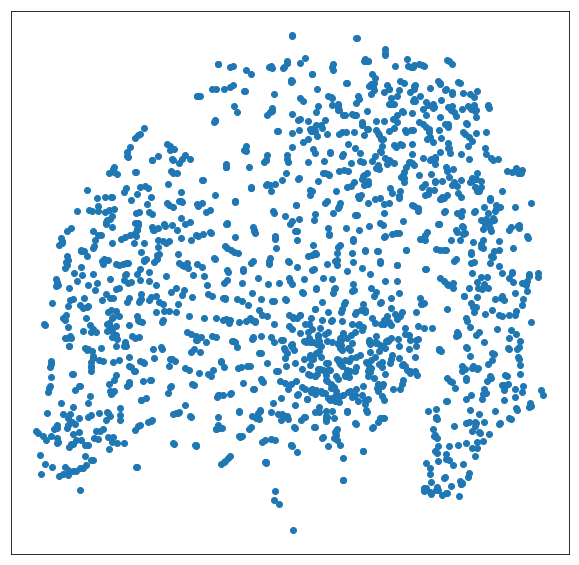

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

## Using item metadata in the model

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata. The resulting system is therefore an **Hybrid Recommender System** that does both **Collaborative Filtering** and **Content-based recommendations**.

<img src="images/rec_archi_3.svg" style="width: 600px;" />


In [86]:
# transform the date (string) into an int representing the release year
parsed_dates = [int(film_date[-4:])
                for film_date in items["date"].tolist()]

items['parsed_date'] = pd.Series(parsed_dates, index=items.index)
max_date = max(items['parsed_date'])
min_date = min(items['parsed_date'])

from sklearn.preprocessing import scale

items['scaled_date'] = scale(items['parsed_date'].astype('float64'))
item_meta_train = items["scaled_date"][item_id_train]
item_meta_test = items["scaled_date"][item_id_test]

len(item_meta_train), len(item_meta_test)

(80000, 20000)

In [87]:
items["scaled_date"].describe()

count    1.682000e+03
mean    -2.415758e-15
std      1.000297e+00
min     -4.730390e+00
25%      2.533563e-01
50%      3.937435e-01
75%      4.639372e-01
max      6.043244e-01
Name: scaled_date, dtype: float64

In [88]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[1], name='meta_item')

embedding_size = 32
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)


# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs, meta_input], mode='concat')

x = Dense(64, activation='relu')(input_vecs)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
y = Dense(1)(x)

model = Model(input=[user_id_input, item_id_input, meta_input], output=y)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train, item_meta_train])

In [89]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train], rating_train,
                    batch_size=64, nb_epoch=15, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 7s - loss: 0.9815 - val_loss: 0.7751
Epoch 2/15
72000/72000 [==============================] - 6s - loss: 0.7699 - val_loss: 0.7621
Epoch 3/15
72000/72000 [==============================] - 6s - loss: 0.7443 - val_loss: 0.7489
Epoch 4/15
72000/72000 [==============================] - 6s - loss: 0.7285 - val_loss: 0.7425
Epoch 5/15
72000/72000 [==============================] - 6s - loss: 0.7095 - val_loss: 0.7483
Epoch 6/15
72000/72000 [==============================] - 6s - loss: 0.6928 - val_loss: 0.7351
Epoch 7/15
72000/72000 [==============================] - 6s - loss: 0.6810 - val_loss: 0.7349
Epoch 8/15
72000/72000 [==============================] - 6s - loss: 0.6722 - val_loss: 0.7318
Epoch 9/15
72000/72000 [==============================] - 7s - loss: 0.6646 - val_loss: 0.7288
Epoch 10/15
72000/72000 [==============================] - 7s - loss: 0.6594 - val_loss: 0.7271


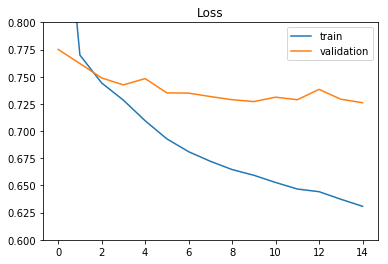

In [91]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.6, 0.8)
plt.legend(loc='best')
plt.title('Loss');

In [92]:
test_preds = model.predict([user_id_test, item_id_test, item_meta_test])
print("Final test Loss: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test Loss: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test Loss: 0.957
Final test Loss: 0.715


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user, that he/she hasn't already seen:
- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a reco function that sorts these items and exclude those the user has already seen

In [94]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_movies = list(all_ratings[all_ratings["user_id"]==user_id]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))
    
    print("user "+str(user_id) +" has seen "+str(len(seen_movies)) + " movies. "+
          "Computing ratings for "+str(len(item_ids))+ " other movies")
    
    item_ids = np.array(item_ids)
    user = np.zeros_like(item_ids)
    user[:]=user_id
    items_meta = items["scaled_date"][item_ids].values
    
    rating_preds = model.predict([user, item_ids, items_meta])
    
    item_ids = np.argsort(rating_preds[:,0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["name"][movie], rating_preds[movie][0]) for movie in rec_items]

In [98]:
recommend(3, top_n=5)

user 3 has seen 54 movies. Computing ratings for 1627 other movies


[("Pharaoh's Army (1995)", 4.7507343),
 ('Land Before Time III: The Time of the Great Giving (1995) (V)', 4.7402701),
 ('Hurricane Streets (1998)', 4.7265635),
 ('A Chef in Love (1996)', 4.6101389),
 ('Office Killer (1997)', 4.4334855)]

### Home assignment: Predicting ratings as a classification problem

In this dataset, the ratings all belong to a finite set of possible values:

In [99]:
import numpy as np

np.unique(rating_train)

array([1, 2, 3, 4, 5], dtype=int64)

Maybe we can help the model by forcing it to predict those values by treating the problem as a multiclassification problem. The only required changes are:

- setting the final layer to output class membership probabities using a softmax activation with 5 outputs;
- optimize the categorical cross-entropy classification loss instead of a regression loss such as MSE or MAE.

Random init MSE: 2.194
Random init MAE: 1.145
Train on 72000 samples, validate on 8000 samples
Epoch 1/6
72000/72000 [==============================] - 7s - loss: 1.3664 - val_loss: 1.2883
Epoch 2/6
72000/72000 [==============================] - 7s - loss: 1.2816 - val_loss: 1.2770
Epoch 3/6
72000/72000 [==============================] - 7s - loss: 1.2637 - val_loss: 1.2659
Epoch 4/6
72000/72000 [==============================] - 7s - loss: 1.2506 - val_loss: 1.2647
Epoch 5/6
72000/72000 [==============================] - 6s - loss: 1.2440 - val_loss: 1.2625
Epoch 6/6
72000/72000 [==============================] - 6s - loss: 1.2384 - val_loss: 1.2590
Final test MSE: 1.187
Final test MAE: 0.728


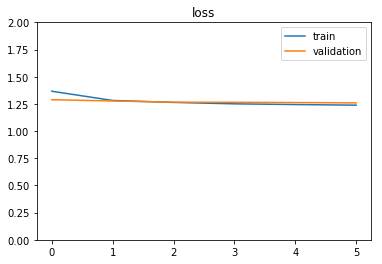

In [101]:
# %load solutions/classification.py
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 16
dense_size = 128
dropout_embedding = 0.5
dropout_hidden = 0.2

user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')
input_vecs = Dropout(dropout_embedding)(input_vecs)

x = Dense(dense_size, activation='relu')(input_vecs)
x = Dropout(dropout_hidden)(x)
x = Dense(dense_size, activation='relu')(x)
y = Dense(output_dim=5, activation='softmax')(x)

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

initial_train_preds = model.predict([user_id_train, item_id_train]).argmax(axis=1) + 1
print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))


history = model.fit([user_id_train, item_id_train], rating_train - 1,
                    batch_size=64, nb_epoch=6, validation_split=0.1,
                    shuffle=True)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('loss');

test_preds = model.predict([user_id_test, item_id_test]).argmax(axis=1) + 1
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
